<a href="https://colab.research.google.com/github/Fatikah002/PCVK_Fatikah/blob/main/Week9_Thresholding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Langkah 1
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Langkah 2
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

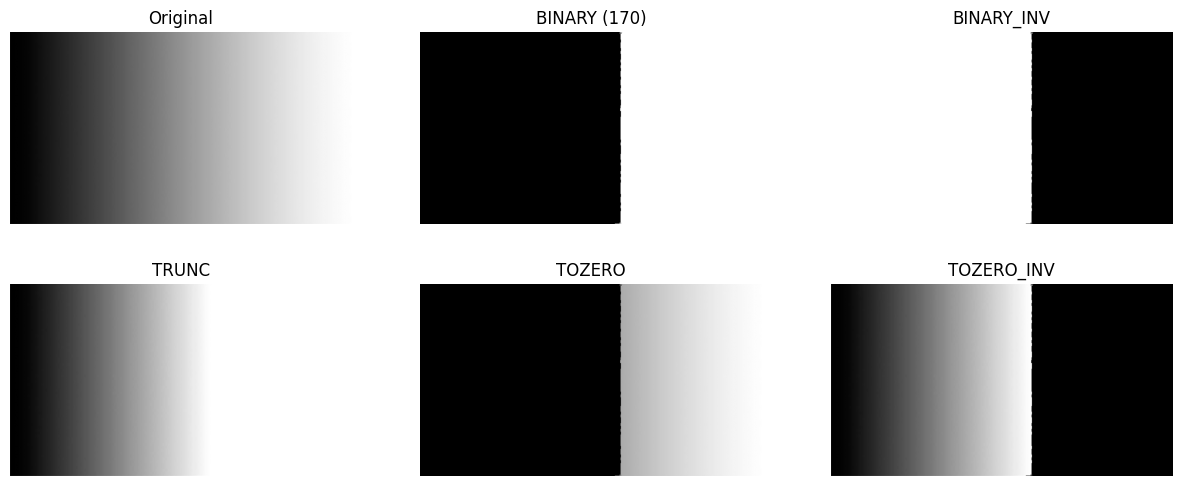

In [10]:
# Langkah 3 - Global threshold
# Ganti path ke gambar Anda (contoh: gradient.jpg)
filename = '/content/drive/MyDrive/PCVK/Images/gradient.jpg'
img = cv.imread(filename, cv.IMREAD_GRAYSCALE)  # gunakan grayscale untuk threshold global
th = 170

ret1, th_binary = cv.threshold(img, th, 255, cv.THRESH_BINARY)
ret2, th_binary_inv = cv.threshold(img, th, 255, cv.THRESH_BINARY_INV)
ret3, th_trunc = cv.threshold(img, th, 255, cv.THRESH_TRUNC)
ret4, th_tozero = cv.threshold(img, th, 255, cv.THRESH_TOZERO)
ret5, th_tozero_inv = cv.threshold(img, th, 255, cv.THRESH_TOZERO_INV)

titles = ['Original','BINARY (170)','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, th_binary, th_binary_inv, th_trunc, th_tozero, th_tozero_inv]

plt.figure(figsize=(15,6))
for i in range(len(images)):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.show()


Otsu manual threshold: 167


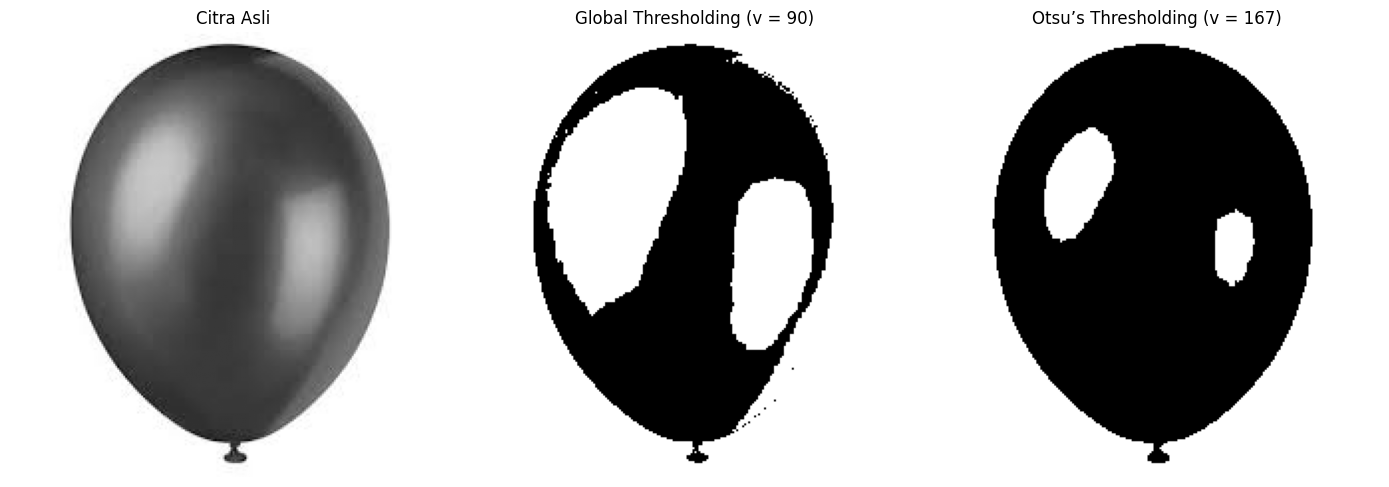

In [20]:
filename = '/content/drive/MyDrive/PCVK/Images/balloon.jpeg'  # ubah sesuai path kamu
img_color = cv.imread(filename)

if img_color is None:
    raise FileNotFoundError(f"Gambar tidak ditemukan di: {filename}")

img = cv.cvtColor(img_color, cv.COLOR_BGR2GRAY)

# 2. Global Threshold (v = 90)
v_global = 90
_, th_global = cv.threshold(img, v_global, 255, cv.THRESH_BINARY)

# 3. Otsu Manual Threshold
def otsu_between(gray):
    hist = cv.calcHist([gray],[0],None,[256],[0,256]).flatten()
    total = gray.size
    prob = hist / total
    cum_prob = np.cumsum(prob)
    cum_mean = np.cumsum(np.arange(256) * prob)
    global_mean = cum_mean[-1]

    best_t = 0
    max_between_var = 0

    for t in range(256):
        w0 = cum_prob[t]
        w1 = 1 - w0
        if w0 == 0 or w1 == 0:
            continue
        mu0 = cum_mean[t] / w0
        mu1 = (global_mean - cum_mean[t]) / w1
        between_var = w0 * w1 * (mu0 - mu1) ** 2
        if between_var > max_between_var:
            max_between_var = between_var
            best_t = t
    return best_t

best_t = otsu_between(img)
print("Otsu manual threshold:", best_t)

# Terapkan hasil threshold
_, th_otsu = cv.threshold(img, best_t, 255, cv.THRESH_BINARY)

# 4. Tampilkan hasil seperti di modul
plt.figure(figsize=(14,5))

plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title("Citra Asli")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(th_global, cmap='gray')
plt.title(f"Global Thresholding (v = {v_global})")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(th_otsu, cmap='gray')
plt.title(f"Otsu’s Thresholding (v = {best_t})")
plt.axis('off')

plt.tight_layout()
plt.show()

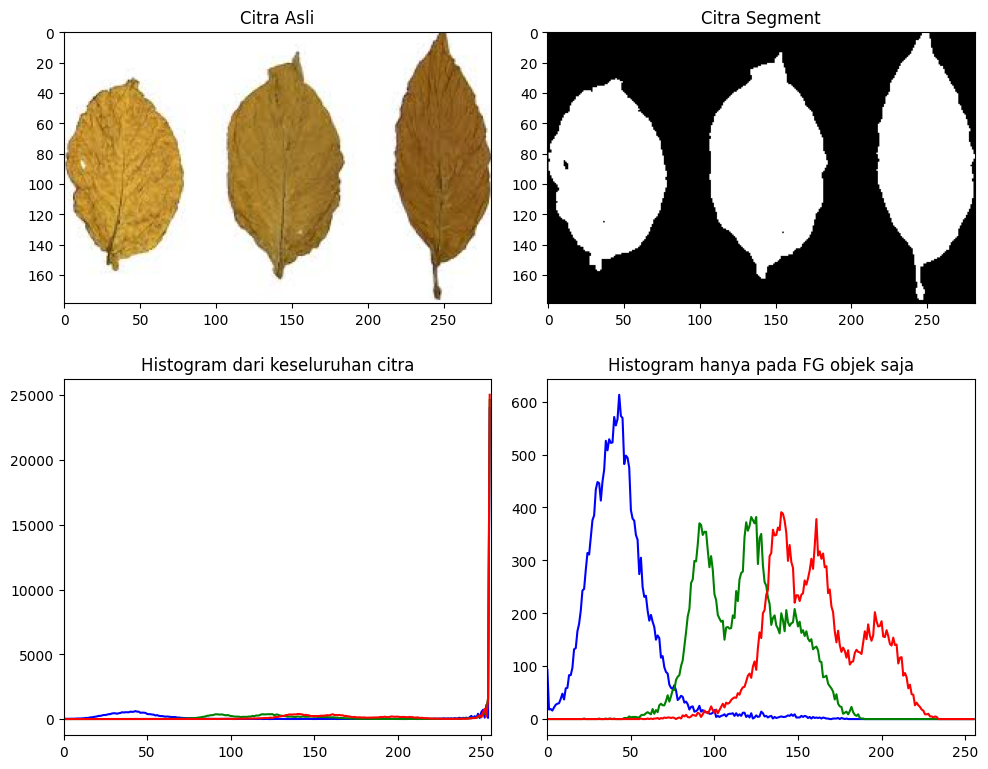

In [30]:
# Langkah 5 - citra tersegmentasi
filename = '/content/drive/MyDrive/PCVK/Images/tobacco.jpeg'
img_color = cv.imread(filename)

if img_color is None:
    raise FileNotFoundError(f"Gambar tidak ditemukan di: {filename}")

img_gray = cv.cvtColor(img_color, cv.COLOR_BGR2GRAY)

# Segmentasi (Otsu threshold)
ret, mask = cv.threshold(img_gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
mask = cv.bitwise_not(mask)  # optional: balik mask agar daun jadi putih (seperti contoh)

# Tampilkan citra asli & hasil segmentasi
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.imshow(cv.cvtColor(img_color, cv.COLOR_BGR2RGB))
plt.title("Citra Asli")

plt.subplot(2,2,2)
plt.imshow(mask, cmap='gray')
plt.title("Citra Segment")

# Histogram dari keseluruhan citra (RGB)
plt.subplot(2,2,3)
colors = ('b','g','r')
for i,col in enumerate(colors):
    hist = cv.calcHist([img_color],[i],None,[256],[0,256])
    plt.plot(hist, color=col)
plt.title("Histogram dari keseluruhan citra")
plt.xlim([0,256])

#  Histogram hanya pada FG (objek daun saja)
plt.subplot(2,2,4)
for i,col in enumerate(colors):
    hist_fg = cv.calcHist([img_color],[i],mask,[256],[0,256])
    plt.plot(hist_fg, color=col)
plt.title("Histogram hanya pada FG objek saja")
plt.xlim([0,256])

plt.tight_layout()
plt.show()


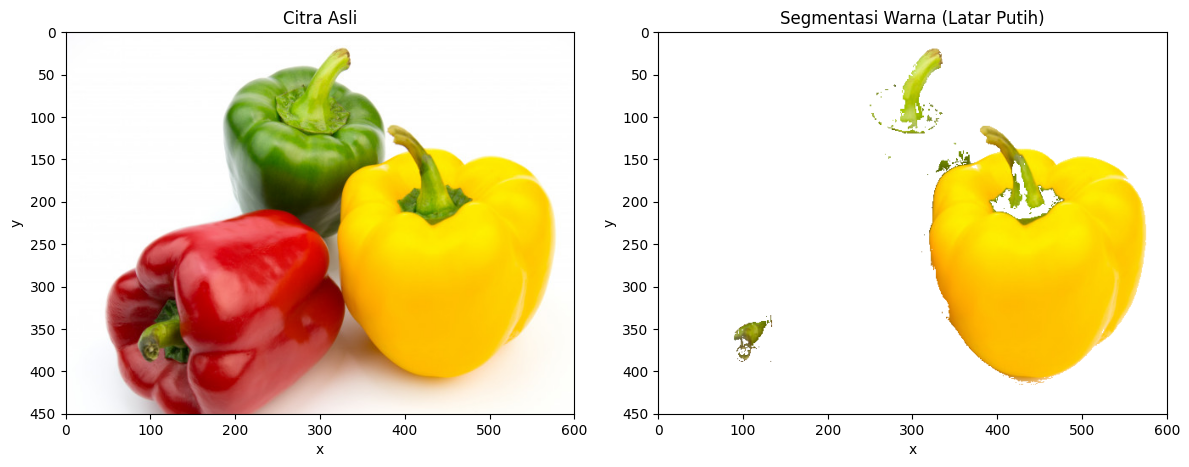

In [34]:
# Langkah 6 - Segmentasi warna
# KMeans pada RGB, pilih cluster paling dekat ke warna 'kuning' (RGB ~ [255,255,0])
filename = '/content/drive/MyDrive/PCVK/Images/peppers.jpg'
img_bgr = cv.imread(filename)

if img_bgr is None:
    raise FileNotFoundError(f"Gambar tidak ditemukan di: {filename}")

# Konversi ke RGB untuk ditampilkan dengan benar di matplotlib
img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)

#  Ubah ke HSV untuk segmentasi warna kuning
hsv = cv.cvtColor(img_bgr, cv.COLOR_BGR2HSV)

# Rentang warna kuning dalam HSV
lower_yellow = np.array([18, 100, 100])
upper_yellow = np.array([35, 255, 255])

# Mask hanya untuk piksel dalam rentang kuning
mask = cv.inRange(hsv, lower_yellow, upper_yellow)

# Buat mask kebalikannya (latar belakang jadi putih)
mask_inv = cv.bitwise_not(mask)

# Buat latar belakang putih
white_background = np.full_like(img_rgb, 255) # Membuat gambar putih dengan ukuran yang sama

# Ambil hanya objek (foreground) dari citra asli menggunakan mask
foreground = cv.bitwise_and(img_rgb, img_rgb, mask=mask)

# Ambil hanya latar belakang putih menggunakan mask_inv
background = cv.bitwise_and(white_background, white_background, mask=mask_inv)

# Gabungkan foreground dan background
result_white_bg = cv.add(foreground, background)


# Tampilkan hasil seperti di modul
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([0,600])
plt.ylim([450,0])
plt.grid(False)
plt.title("Citra Asli")


plt.subplot(1,2,2)
plt.imshow(result_white_bg) # Tampilkan hasil dengan latar belakang putih
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([0,600])
plt.ylim([450,0])
plt.grid(False)
plt.title("Segmentasi Warna (Latar Putih)")

plt.tight_layout()
plt.show()

**Saat anda menampilkan warna tertentu, jelaskan kendala yang di hadapi dan mengapa hal itu terjadi.**
*   karena ketergantungan tinggi terhadap kondisi pencahayaan dan variasi warna dalam citra.

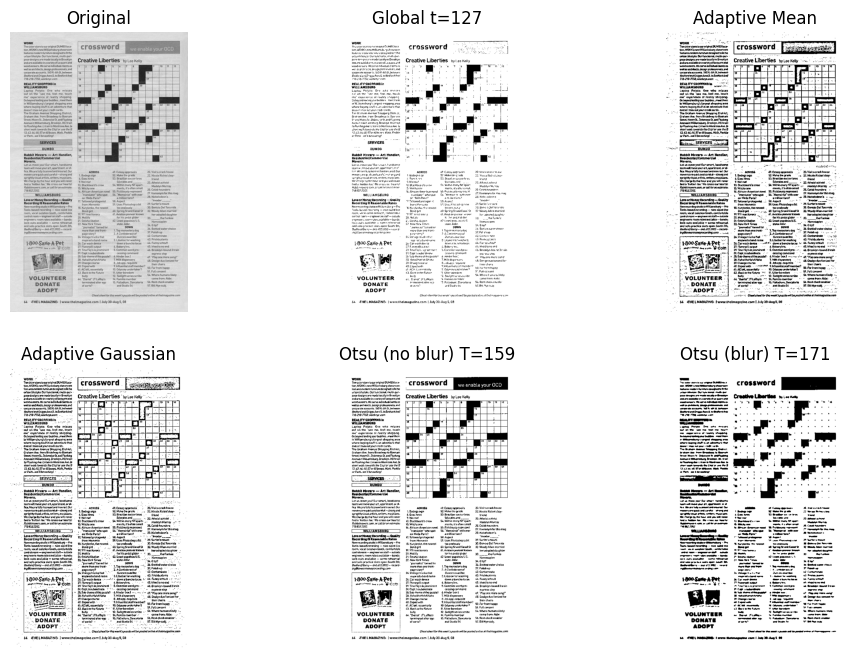

In [35]:
# Langkah 7
filename = '/content/drive/MyDrive/PCVK/Images/crossword.jpg'
img = cv.imread(filename, cv.IMREAD_GRAYSCALE)

# 1. Global binary (contoh t=127)
ret, th_global = cv.threshold(img, 127, 255, cv.THRESH_BINARY)

# 2. Adaptive Mean
th_adapt_mean = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_MEAN_C,
                                     cv.THRESH_BINARY, blockSize=15, C=8)

# 3. Adaptive Gaussian
th_adapt_gauss = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv.THRESH_BINARY, blockSize=15, C=8)

# 4. Otsu's with and without Gaussian blur
ret1, th_otsu = cv.threshold(img, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
blur = cv.GaussianBlur(img, (5,5), 0)
ret2, th_otsu_blur = cv.threshold(blur, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

plt.figure(figsize=(12,8))
plt.subplot(2,3,1); plt.imshow(img,'gray'); plt.title('Original'); plt.axis('off')
plt.subplot(2,3,2); plt.imshow(th_global,'gray'); plt.title('Global t=127'); plt.axis('off')
plt.subplot(2,3,3); plt.imshow(th_adapt_mean,'gray'); plt.title('Adaptive Mean'); plt.axis('off')
plt.subplot(2,3,4); plt.imshow(th_adapt_gauss,'gray'); plt.title('Adaptive Gaussian'); plt.axis('off')
plt.subplot(2,3,5); plt.imshow(th_otsu,'gray'); plt.title(f"Otsu (no blur) T={int(ret1)}"); plt.axis('off')
plt.subplot(2,3,6); plt.imshow(th_otsu_blur,'gray'); plt.title(f"Otsu (blur) T={int(ret2)}"); plt.axis('off')
plt.show()
